In [15]:
import numpy as np
import random 

import matplotlib.pyplot as plt 

from keras.models import Sequential  
from keras.callbacks import EarlyStopping

from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import utils
from tensorflow.keras.optimizers import SGD

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

In [16]:
data_train = np.load('kmnist-train-imgs.npz')
labels_train = np.load('kmnist-train-labels.npz')
data_test = np.load('kmnist-test-imgs.npz')
labels_test = np.load('kmnist-test-labels.npz')

In [17]:
k_train_samples = data_train['arr_0']
k_train_labels = labels_train['arr_0']
k_test_samples = data_test['arr_0']
k_test_labels = labels_test['arr_0']

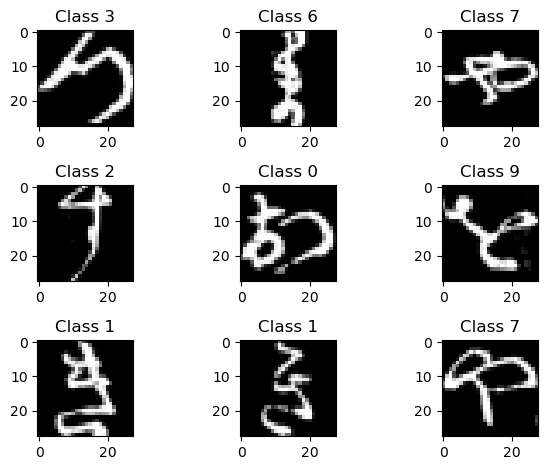

In [18]:
for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(k_train_samples))
    plt.imshow(k_train_samples[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(k_train_labels[num]))
    
plt.tight_layout()

In [19]:
X_train = k_train_samples.reshape(60000, 784) 
X_test = k_test_samples.reshape(10000, 784)   

X_train = X_train.astype('float32')   
X_test = X_test.astype('float32')

X_train /= 255                        
X_test /= 255

X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


In [20]:
no_classes = 10

Y_train = utils.to_categorical(k_train_labels, no_classes)
Y_test = utils.to_categorical(k_test_labels, no_classes)

In [21]:
models = []
for i in range(1,5):
    model = Sequential()
    model.add(Conv2D(32,(3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(28,28,1)))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(i*10, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    models.append(model)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_24 (Flatten)        (None, 5408)              0         
                                                                 
 dense_48 (Dense)            (None, 10)                54090     
                                                                 
 dense_49 (Dense)            (None, 10)                110       
                                                                 
Total params: 54520 (212.97 KB)
Trainable params: 54520 (212.97 KB)
Non-trainable params: 0 (0.00 Byte)
_______________

In [22]:
#from keras.utils import plot_model
#plot_model(model, to_file='model_chart.png', show_shapes=True, show_layer_names=True)
#from IPython.display import Image
#Image("model_chart.png")

In [32]:
lr = [0.0001, 0.001, 0.01, 0.1, 1]
m = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
chosen_lr = []
chosen_m = []
for model in models:
    temp_lr = random.choice(lr)
    temp_m = random.choice(m)
    chosen_lr.append(temp_lr)
    chosen_m.append(temp_m)
    opt = SGD(learning_rate=temp_lr, momentum=temp_m)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
callback = EarlyStopping(monitor='loss', patience=1, min_delta=0.1)
histories = []
for model in models:
    histories.append( model.fit(X_train, Y_train,
              batch_size=128, epochs=10,
              verbose=1, callbacks=[callback]))

Epoch 1/10
469/469 [==============================] - 6s 11ms/step - loss: 0.1094 - accuracy: 0.9693
Epoch 2/10
469/469 [==============================] - 5s 11ms/step - loss: 0.0979 - accuracy: 0.9729
Epoch 1/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0822 - accuracy: 0.9753
Epoch 2/10
469/469 [==============================] - 5s 11ms/step - loss: 0.0761 - accuracy: 0.9775
Epoch 1/10
469/469 [==============================] - 6s 11ms/step - loss: 0.0593 - accuracy: 0.9819
Epoch 2/10
469/469 [==============================] - 6s 13ms/step - loss: 0.0582 - accuracy: 0.9822
Epoch 1/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0576 - accuracy: 0.9827
Epoch 2/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0568 - accuracy: 0.9829


In [25]:
len(histories)

4

In [34]:
find_best_model = []
for history in histories:
    find_best_model.append(history.history['loss'][-1])

index = np.argmin(find_best_model)
best_model = models[index]

print("Chosen Model: " + str(index))
print("Final Loss: " + str(find_best_model[index]))
print("Final Accuracy: " + str(histories[index].history['accuracy'][-1]))
print("Final Learning Rate: " + str(chosen_lr[index]))
print("Final Momentum: " + str(chosen_m[index]))

Chosen Model: 3
Final Loss: 0.05681043863296509
Final Accuracy: 0.98294997215271
Final Learning Rate: 0.0001
Final Momentum: 0.1


In [35]:
score = model.evaluate(X_test, Y_test)
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.3802 - accuracy: 0.9068
Test accuracy: 0.9067999720573425


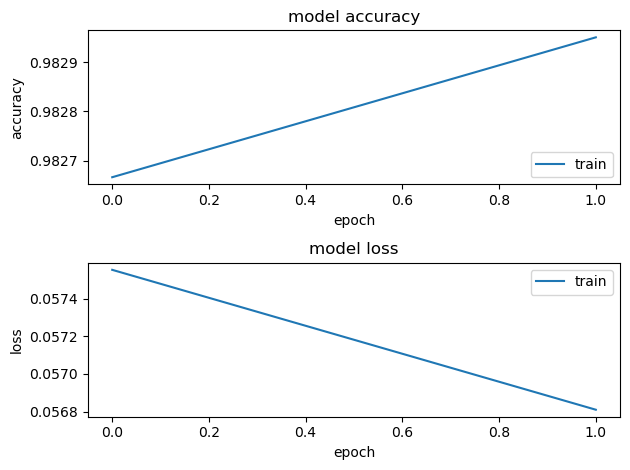

In [36]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(histories[index].history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(histories[index].history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

In [37]:
results = best_model.predict(X_test)

313/313 [==============================] - 1s 2ms/step


313/313 [==============================] - 0s 2ms/step
Accuracy: 0.9068
Weighted Precision: 0.9088179565301647
Weighted Recall: 0.9068
Weighted F1 Score: 0.9069946885532583


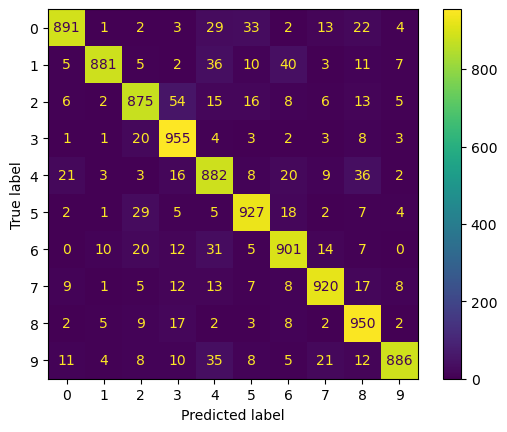

In [38]:
predicted_classes = best_model.predict(X_test)

true_labels = np.argmax(Y_test,axis=1)

predicted_labels = np.argmax(predicted_classes,axis=1)

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

print("Accuracy: " + str(accuracy_score(true_labels, predicted_labels)))
print("Weighted Precision: " + str(precision_score(true_labels, predicted_labels, average='weighted')))
print("Weighted Recall: " + str(recall_score(true_labels, predicted_labels, average='weighted')))
print("Weighted F1 Score: " + str(f1_score(true_labels, predicted_labels, average='weighted')))

### Extensions to the project
1. Alter parameters of layers (Number of perceptrons, more Convolution and pooling layers) 
2. Preprocessing on the data (filter?)
3. Ensemble learning
4. Utilize Graphcore IPU